***
# Evaluation of Different RPLH Systems
***
Both performing aggregated analysis (per trial) and step analysis (per environmental steps)

In [9]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt

current_folder = Path.cwd()
parent_folder = current_folder.parent.parent
sys.path.insert(0, str(parent_folder))
print(parent_folder)

from rplh.evaluation.get_data import get_data
from rplh.evaluation.embed import *
from rplh.evaluation.energy import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/kevinb/Desktop/dsc190/RPLH


# Importing Data With Our Getter Functions

In [10]:
print("LOADING RPLH-SPY-AGENT...")
base_dir = parent_folder / "gpt-agent-testing-env-3up"
df_a_spy, success_df_a_spy, spy_count_df, spy_df, att_df, justification_df, dist_a_spy = get_data(base_dir, 20)

print("\nLOADING RPLH-SPY-STANDARD...")
base_dir = parent_folder / "gpt-standard-testing-env-3up"
df_s_spy, success_df_s_spy, _, _, _, justification_df_standard, dist_s_spy = get_data(base_dir, 20)

print("\nLOADING RPLH-NoSPY-STANDADRD...")
base_dir = parent_folder / "gpt-standard-testing-nospy-env-2up"
df_s_nospy, success_df_s_nospy, _, _, _, _, dist_s_nospy = get_data(base_dir, 20)

LOADING RPLH-SPY-AGENT...
trial_6: Not Converged
trial_7: Not Converged
trial_15: Not Converged
trial_17: Not Converged
trial_19: Not Converged
trial_20: Not Converged

LOADING RPLH-SPY-STANDARD...
trial_1: Not Converged
trial_3: Not Converged
trial_4: Not Converged
trial_7: Not Converged
trial_9: Not Converged
trial_12: Not Converged
trial_16: Not Converged
trial_17: Not Converged
trial_18: Not Converged

LOADING RPLH-NoSPY-STANDADRD...
trial_3: Not Converged
trial_7: Not Converged
trial_8: Not Converged
trial_9: Not Converged
trial_11: Not Converged
trial_13: Not Converged
trial_14: Not Converged
trial_17: Not Converged


In [11]:
agent_spy_merged = df_a_spy.merge(success_df_a_spy, on="Trial")
standard_spy_merged = df_s_spy.merge(success_df_s_spy, on="Trial")
standard_nospy_merged = df_s_nospy.merge(success_df_s_nospy, on="Trial")

In [12]:
agent_round = spy_count_df.divide(spy_count_df.sum(axis=1), axis=0).round(2)
agent_round.idxmax(axis=1).value_counts()

Agent[1.5, 1.5]    9
Agent[0.5, 1.5]    7
Agent[1.5, 0.5]    2
Agent[2.5, 2.5]    1
Agent[2.5, 1.5]    1
Name: count, dtype: int64

***
# Norm Distance Metrics Per-Trial
***

1. Area under the steps is the `energy` or all the steps needed for a system to converge (only converged ones are used)
2. Slope is convergence speed
3. Agent spy's environment is more complicated

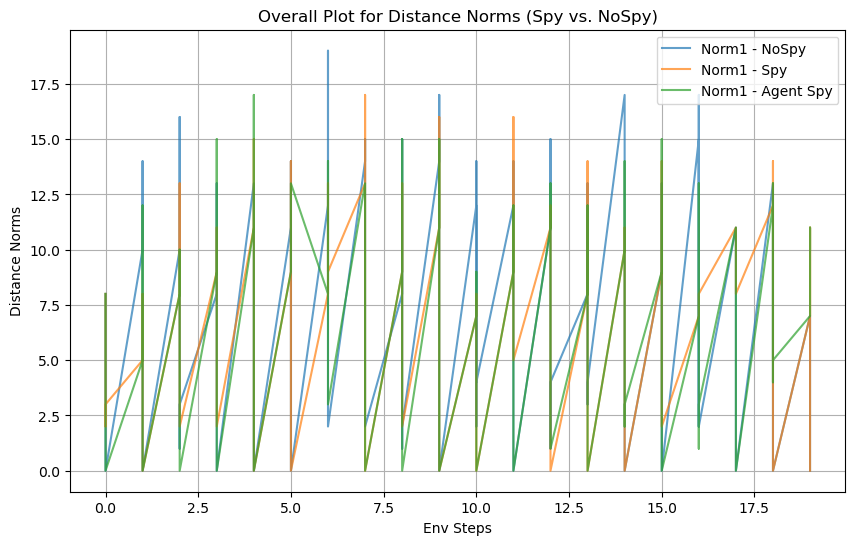

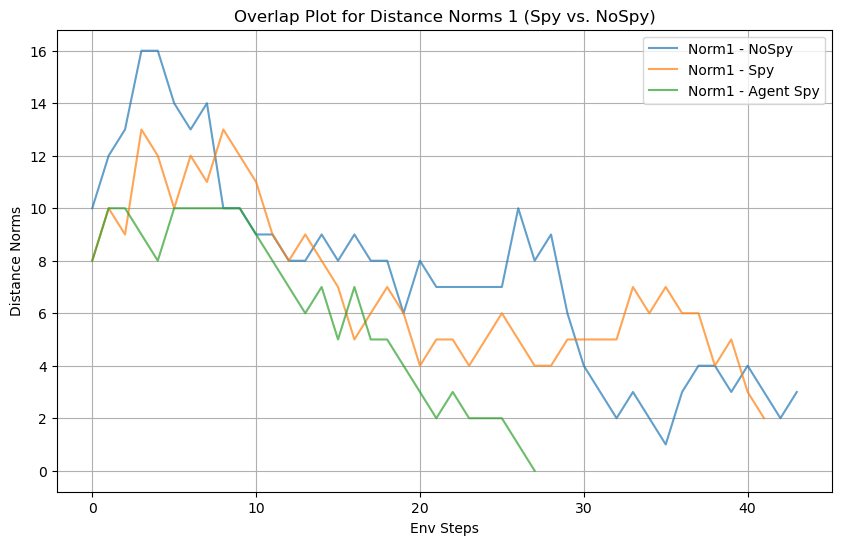

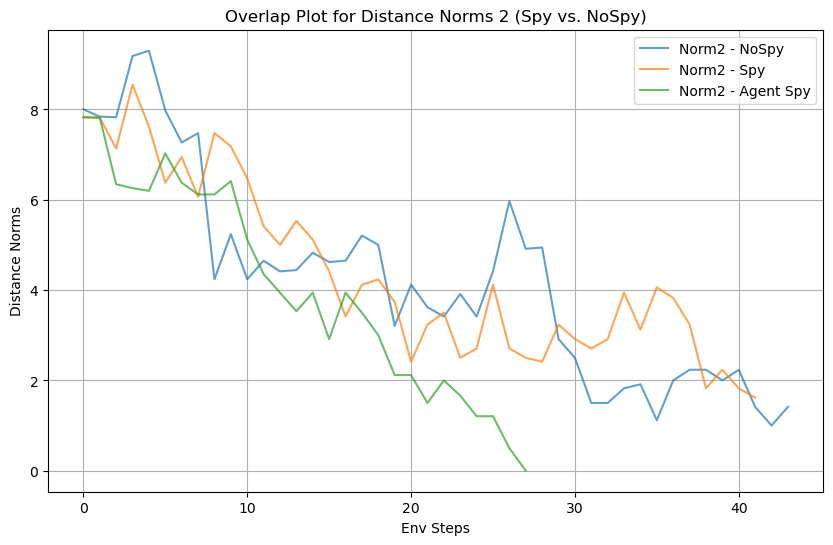

In [108]:
plot_env_progression(dist_a_spy, dist_s_spy, dist_s_nospy, get_trial=2)

We only want to compare the converged ones for `AUC` metric

In [109]:
agent_spy_dist_merged = dist_a_spy.merge(success_df_a_spy, on="Trial")
standard_spy_dist_merged = dist_s_spy.merge(success_df_s_spy, on="Trial")
standard_nospy_dist_merged = dist_s_nospy.merge(success_df_s_nospy, on="Trial")

In [110]:
all_a_spy = agent_spy_dist_merged[agent_spy_dist_merged["Convergence"] == "Converged"].drop(columns=["Trial"]).reset_index(drop=True)
all_spy = standard_spy_dist_merged[standard_spy_dist_merged["Convergence"] == "Converged"].drop(columns=["Trial"]).reset_index(drop=True)
all_nospy = standard_nospy_dist_merged[standard_nospy_dist_merged["Convergence"] == "Converged"].drop(columns=["Trial"]).reset_index(drop=True)

We need to preprocess the data, including reassigning `trial number` and `env step number`

In [111]:
new_a_dist = dist_df_process(all_a_spy)
new_s_dist = dist_df_process(all_spy)
new_s_nospy_dist = dist_df_process(all_nospy)

In [112]:
new_a_dist

,env_step,trial,Norm1,Norm2
0,0,0,8.0,3.831394
1,1,0,4.0,2.602736
2,2,0,4.0,2.602736
3,3,0,4.0,2.602736
4,4,0,4.0,2.602736
...,...,...,...,...
360,16,13,2.0,1.000000
361,17,13,2.0,1.000000
362,18,13,2.0,1.000000
363,19,13,1.0,0.000000


Check filtered

In [113]:
new_a_dist['trial'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [114]:
new_s_dist['trial'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [115]:
new_s_nospy_dist['trial'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

Calculate the total `AUC` metrics

In [116]:
calculate_auc(new_a_dist)

Overall AUC for Norm1: 187.71428571428572
Overall AUC for Norm2: 108.59262775932079


In [117]:
calculate_auc(new_s_dist)

Overall AUC for Norm1: 228.8181818181818
Overall AUC for Norm2: 133.27889394692093


In [118]:
calculate_auc(new_s_nospy_dist)

Overall AUC for Norm1: 160.29166666666666
Overall AUC for Norm2: 87.45310554402722


Let's do a regression line. A more negative slope in the context of this regression indicates a faster rate of decline in the dependent variable (distance metrics)

In [119]:
calculate_slope(new_a_dist)

Average slope for Norm1: -0.38765125806035183
Average slope for Norm2: -0.2704926585392068


In [120]:
calculate_slope(new_s_dist)

Average slope for Norm1: -0.3326826865160759
Average slope for Norm2: -0.23993066999109416


In [121]:
calculate_slope(new_s_nospy_dist)

Average slope for Norm1: -0.5668572673651545
Average slope for Norm2: -0.3335389614962636


***
# Aggregated Senetnce Embedding Analysis
***

Easiest idea, let's `explode()` all the sentence respond in agent models to see similarity with given spy or non-spy sentence.

Test to see if embedding function working.

In [54]:
sentence1 = "The cat sat on the mat."
sentence2 = "A cat was sitting on the mat."

embedding_1 = get_embedding(sentence1)
embedding_2 = get_embedding(sentence2)

cosine_sim(embedding_1, embedding_2)

0.9777018864480065

Need to check last few ones

### Compare aggregated nice senntence with nice agent spy agent in `att_df`

In [55]:
sentence1 = "Seems to be be very easy going, trying to find agreement with the central ageent and the goal is to resolve conversation."
sentence2 = "".join(str(att_df['Agent[2.5, 1.5]'].explode().unique()))
sentence3 = "".join(str(att_df['Agent[2.5, 0.5]'].explode().unique()))
sentence4 = "".join(str(att_df['Agent[1.5, 1.5]'].explode().unique()))

print(f"Compare represenattion between nice sentence and nice agent: {cosine_sim(get_embedding(sentence1), get_embedding(sentence3))}")
print(f"Compare representation between nice sentence and spy agent: {cosine_sim(get_embedding(sentence1), get_embedding(sentence4))}")
print(f"Compare represenattion of 2 nice agent: {cosine_sim(get_embedding(sentence2), get_embedding(sentence3))}")

Compare represenattion between nice sentence and nice agent: 0.477384468842258
Compare representation between nice sentence and spy agent: 0.41071185602423244
Compare represenattion of 2 nice agent: 0.9030917904335105


### Compare aggregated spy sentence with non-spy agent and spy agent in `att_df`

In [56]:
sentence1 = "Seems to be the spy agent, its goal is to prevent match targets."
sentence2 = "".join(str(att_df['Agent[1.5, 1.5]'].explode().unique()))
sentence3 = "".join(str(att_df['Agent[2.5, 0.5]'].explode().unique()))

print(f"Compare represenattion between spy sentence and spy agent: {cosine_sim(get_embedding(sentence1), get_embedding(sentence2))}")
print(f"Compare represenattion between spy sentence and non-spy agent: {cosine_sim(get_embedding(sentence1), get_embedding(sentence3))}")

Compare represenattion between spy sentence and spy agent: 0.6157219010540025
Compare represenattion between spy sentence and non-spy agent: 0.6053309840915431


Aggregated sentence embedding doesn't seem to work so well.

***
# Per-Trial Senetnce Embedding Analysis
***

Let's now use the look at similarity per trial instead of an aggregated sentence we will look at
- `agent model` embedding similarity with spy sentence.
- `spy model` embedding similarity with spy sentence.
- `agent model` embedding similarity with non-spy sentence.
- `justificatoon` embedding with justification sentence to see if suspecting is given.

In [57]:
df_trial_embed = pd.DataFrame()
sentence1 = "Seems to be the spy agent, its goal is to prevent match targets"
sentence2 = "Seems to be be very easy going, trying to find agreement with the central ageent and the goal is to resolve conversation."
sentence3 = "I suspect that this agent is the spy agent, thus, I would not listen to this agent."
embedding_1 = get_embedding(sentence1)
embedding_2 = get_embedding(sentence2)
embedding_3 = get_embedding(sentence3)

df_trial_embed['Att_Embed_SpySent_Agent[1.5, 1.5]'] = att_df.reset_index()['Agent[1.5, 1.5]'].apply(lambda x: cosine_sim(embedding_1, get_embedding(str(x))))
df_trial_embed['Att_Embed_NonSpySent_Agent[1.5, 1.5]'] = att_df.reset_index()['Agent[1.5, 1.5]'].apply(lambda x: cosine_sim(embedding_2, get_embedding(str(x))))
df_trial_embed['Spy_Embed_SpySent_Agent[1.5, 1.5]'] = spy_df.reset_index()['Agent[1.5, 1.5]'].apply(lambda x: cosine_sim(embedding_1, get_embedding(str(x))))
df_trial_embed['Justification_Embed'] = justification_df.reset_index()['Justifications'].apply(lambda x: cosine_sim(embedding_3, get_embedding(str(x))))
df_trial_embed

,"Att_Embed_SpySent_Agent[1.5, 1.5]","Att_Embed_NonSpySent_Agent[1.5, 1.5]","Spy_Embed_SpySent_Agent[1.5, 1.5]",Justification_Embed
0,0.498783,0.431337,0.583837,0.617001
1,0.555409,0.369837,0.634192,0.500486
2,0.579711,0.396482,0.680379,0.650587
3,0.620892,0.446607,0.747992,0.651606
4,0.555391,0.406046,0.599418,0.602094
5,0.560213,0.492380,0.579917,0.598154
6,0.589882,0.488796,0.636751,0.640405
7,0.517687,0.408757,0.561800,0.557793
8,0.487824,0.472294,0.524487,0.624391
9,0.551335,0.437907,0.526782,0.572241


***
# Structured Embedding Similarity Analysis
***

We have written a function to do similar things as the above, but more rigrously and get everything directly.

In [58]:
spy_embedding = get_spy_detect_embedding(agent_spy_merged, spy_df, justification_df,
                                         spy_sentence="Seems to be the spy agent, its goal is to prevent match targets.",
                                         just_sentence="I suspect that this agent is the spy agent, thus, I would not listen to this agent.",
                                         spy_agents=["Agent[0.5, 0.5]", "Agent[1.5, 1.5]", "Agent[2.5, 2.5]"],
                                         only_spy=True)
spy_embedding

,Trial,Num_Boxes,Avg_Boxes_To_Targets_Per_Response,Avg_Boxes_To_Other_Per_Response,Convergence,Num_Responses,"Spy_Embed_Agent[0.5, 0.5]","Spy_Embed_Agent[1.5, 1.5]","Spy_Embed_Agent[2.5, 2.5]",Justification_Embed
0,trial_1,8,0.571429,0.714286,Converged,14,0.675143,0.594204,0.353954,0.617001
1,trial_2,11,0.440000,1.480000,Converged,25,0.647305,0.640134,0.734128,0.500486
2,trial_3,11,0.407407,1.740741,Converged,27,0.618273,0.684246,0.621723,0.650587
3,trial_4,10,0.384615,1.038462,Converged,26,0.657759,0.753357,0.733541,0.651606
4,trial_5,12,0.307692,2.128205,Converged,39,0.528011,0.604009,0.536061,0.602094
5,trial_6,12,0.100000,0.200000,Not Converged,50,0.565911,0.587502,0.577602,0.598154
6,trial_7,10,0.200000,1.688889,Not Converged,45,0.457362,0.647122,0.598549,0.640405
7,trial_8,8,0.380952,1.857143,Converged,21,0.634957,0.565344,0.716670,0.557793
8,trial_9,10,0.400000,1.720000,Converged,25,0.556357,0.529466,0.625864,0.624391
9,trial_10,11,0.458333,1.041667,Converged,24,0.546744,0.529662,0.544890,0.572241


In [59]:
filtered_spy_embed = spy_embedding[spy_embedding['Convergence']=="Converged"].drop(columns=["Avg_Boxes_To_Targets_Per_Response", "Avg_Boxes_To_Other_Per_Response"])
filtered_spy_embed.describe()

,Num_Boxes,Num_Responses,"Spy_Embed_Agent[0.5, 0.5]","Spy_Embed_Agent[1.5, 1.5]","Spy_Embed_Agent[2.5, 2.5]",Justification_Embed
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,9.785714,25.142857,0.570538,0.619103,0.643230,0.615159
std,1.577660,6.780710,0.108039,0.074772,0.109523,0.050114
min,8.000000,14.000000,0.353954,0.529466,0.353954,0.500486
25%,8.000000,20.250000,0.532694,0.567079,0.599519,0.590435
50%,10.000000,25.000000,0.587794,0.599107,0.683120,0.619610
75%,11.000000,27.000000,0.644218,0.673218,0.725615,0.651351
max,12.000000,39.000000,0.711985,0.753357,0.734128,0.698648


In [242]:
# from tabulate import tabulate
# markdown_table = tabulate(filtered_spy_embed.drop(columns=['Num_Boxes', 'Num_Responses']).describe(), headers='keys', tablefmt='pipe')
# print(markdown_table)

Let's use all the features, not just the spy ones

In [61]:
spy_embedding = get_spy_detect_embedding(agent_spy_merged, spy_df, justification_df,
                                         spy_sentence="Seems to be the spy agent, its goal is to prevent match targets.",
                                         just_sentence="I suspect that this agent is the spy agent, thus, I would not listen to this agent.",
                                         spy_agents=["Agent[0.5, 0.5]", "Agent[1.5, 1.5]", "Agent[2.5, 2.5]"],
                                         only_spy=False)

***
# Create Big DF for Correlation Studies
***

We need to combine both upper 2 and upper 3 data together.

In [62]:
standard_for_merge_spy = standard_spy_merged.drop(columns=["Boxes_To_Targets", "Boxes_To_Other"])
standard_for_merge_nospy = standard_nospy_merged.drop(columns=["Boxes_To_Targets", "Boxes_To_Other"])

spy_embedding["Have_spy"] = 1
standard_for_merge_spy["Have_spy"] = 1
standard_for_merge_nospy["Have_spy"] = 0

Creat three dataset:
- Full dataset
- Only spy data
- With convergence info

In [63]:
rplh_df = pd.concat([spy_embedding, standard_for_merge_spy, standard_for_merge_nospy], axis=0, ignore_index=True).drop(columns=["Trial", "Convergence", "Avg_Boxes_To_Other_Per_Response"]).fillna(0)
rplh_df_all_spy = pd.concat([spy_embedding, standard_for_merge_spy], axis=0, ignore_index=True).drop(columns=["Trial", "Convergence", "Avg_Boxes_To_Other_Per_Response", "Have_spy"]).fillna(0)
rplh_df_with_conv = pd.concat([spy_embedding, standard_for_merge_spy, standard_for_merge_nospy], axis=0, ignore_index=True).drop(columns=["Trial", "Avg_Boxes_To_Other_Per_Response"]).fillna(0)

Avg_Boxes_To_Targets_Per_Response    1.000000
Spy_Embed_Agent[1.5, 1.5]            0.268332
Justification_Embed                  0.252639
Spy_Embed_Agent[2.5, 2.5]            0.220533
Spy_Embed_Agent[0.5, 0.5]            0.169998
Num_Boxes                            0.113322
Num_Responses                       -0.779958
Name: Avg_Boxes_To_Targets_Per_Response, dtype: float64


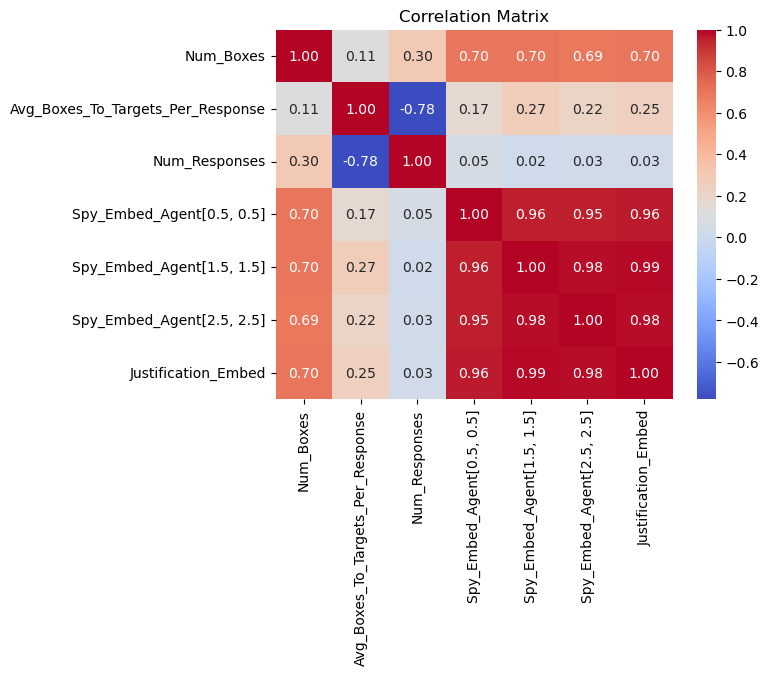

In [64]:
import seaborn as sns

spy_embedding_small = get_spy_detect_embedding(agent_spy_merged, spy_df, justification_df,
                                         spy_sentence="Seems to be the spy agent, its goal is to prevent match targets.",
                                         just_sentence="I suspect that this agent is the spy agent, thus, I would not listen to this agent.",
                                         spy_agents=["Agent[0.5, 0.5]", "Agent[1.5, 1.5]", "Agent[2.5, 2.5]"],
                                         only_spy=True)

rplh_df_small = (pd.concat([spy_embedding_small, standard_for_merge_spy, standard_for_merge_nospy], axis=0, ignore_index=True)
                 .drop(columns=["Trial", "Convergence", "Avg_Boxes_To_Other_Per_Response", "Have_spy"])
                 .fillna(0))

correlation_matrix = rplh_df_small.corr()
target_corr = correlation_matrix["Avg_Boxes_To_Targets_Per_Response"].sort_values(ascending=False)

print(target_corr)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Intuitively speaking, better understanding of who is the spy leads to decreasing in the convergence time (steps/response). We will do hypothesis testing later.

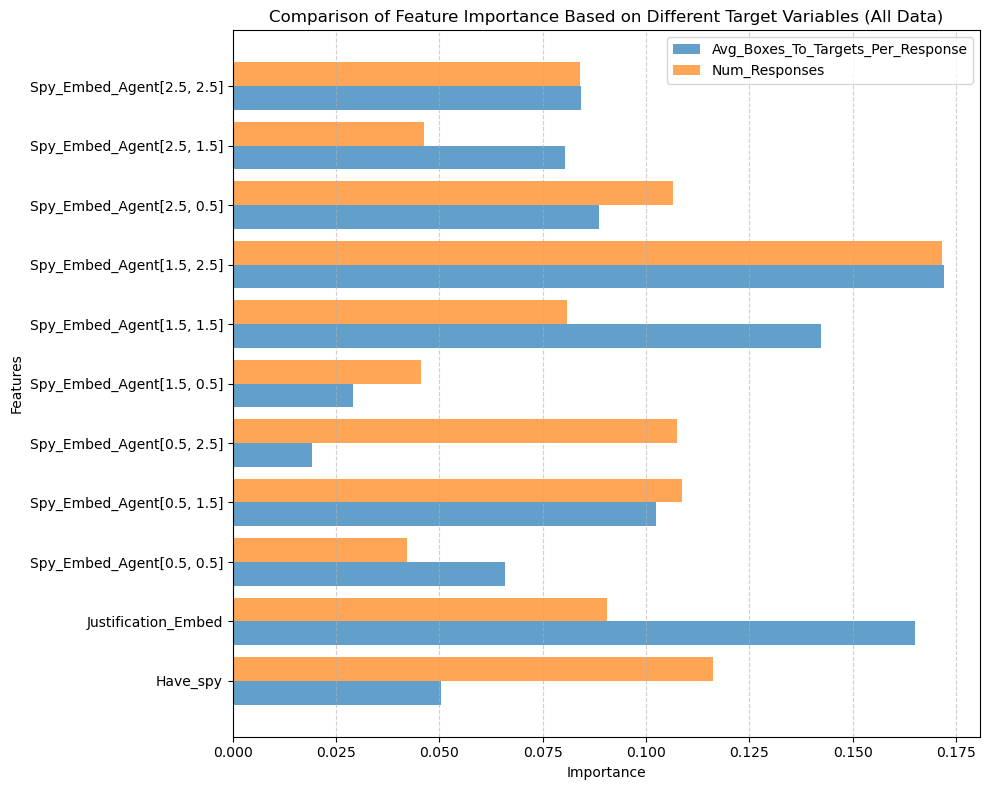

Explained Variance (R^2) for Avg_Boxes_To_Targets_Per_Response: -0.118
Explained Variance (R^2) for Num_Responses: -0.056


In [65]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Model 1: Train on Avg_Boxes_To_Targets_Per_Response
X1 = rplh_df.drop(columns=["Avg_Boxes_To_Targets_Per_Response", "Num_Responses", "Num_Boxes"])
y1 = rplh_df["Avg_Boxes_To_Targets_Per_Response"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
model1 = RandomForestRegressor(random_state=42)
model1.fit(X_train1, y_train1)

# Model 2: Train on Num_Responses
X2 = rplh_df.drop(columns=["Avg_Boxes_To_Targets_Per_Response", "Num_Responses", "Num_Boxes"])
y2 = rplh_df["Num_Responses"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
model2 = RandomForestRegressor(random_state=42)
model2.fit(X_train2, y_train2)

importances1 = pd.Series(model1.feature_importances_, index=X1.columns)
importances2 = pd.Series(model2.feature_importances_, index=X2.columns)

plt.figure(figsize=(10, 8))
y = range(len(importances1))

plt.barh(y, importances1.sort_index(), height=0.4, label="Avg_Boxes_To_Targets_Per_Response", alpha=0.7)
plt.barh([i + 0.4 for i in y], importances2.sort_index(), height=0.4, label="Num_Responses", alpha=0.7)
plt.yticks([i + 0.2 for i in y], importances1.sort_index().index)
plt.title("Comparison of Feature Importance Based on Different Target Variables (All Data)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

explained_variance_model1 = model1.score(X_test1, y_test1)
explained_variance_model2 = model2.score(X_test2, y_test2)
print(f"Explained Variance (R^2) for Avg_Boxes_To_Targets_Per_Response: {explained_variance_model1:.3f}")
print(f"Explained Variance (R^2) for Num_Responses: {explained_variance_model2:.3f}")

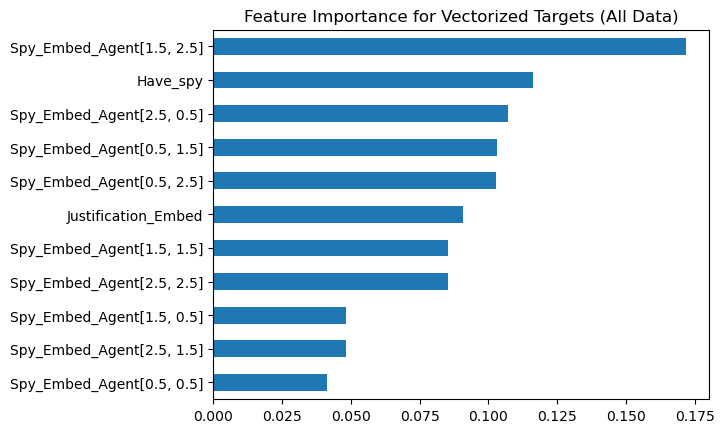

In [66]:
X = rplh_df.drop(columns=["Avg_Boxes_To_Targets_Per_Response", "Num_Responses", "Num_Boxes"])
y = rplh_df[["Num_Responses", "Avg_Boxes_To_Targets_Per_Response"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", title="Feature Importance for Vectorized Targets (All Data)")
plt.show()

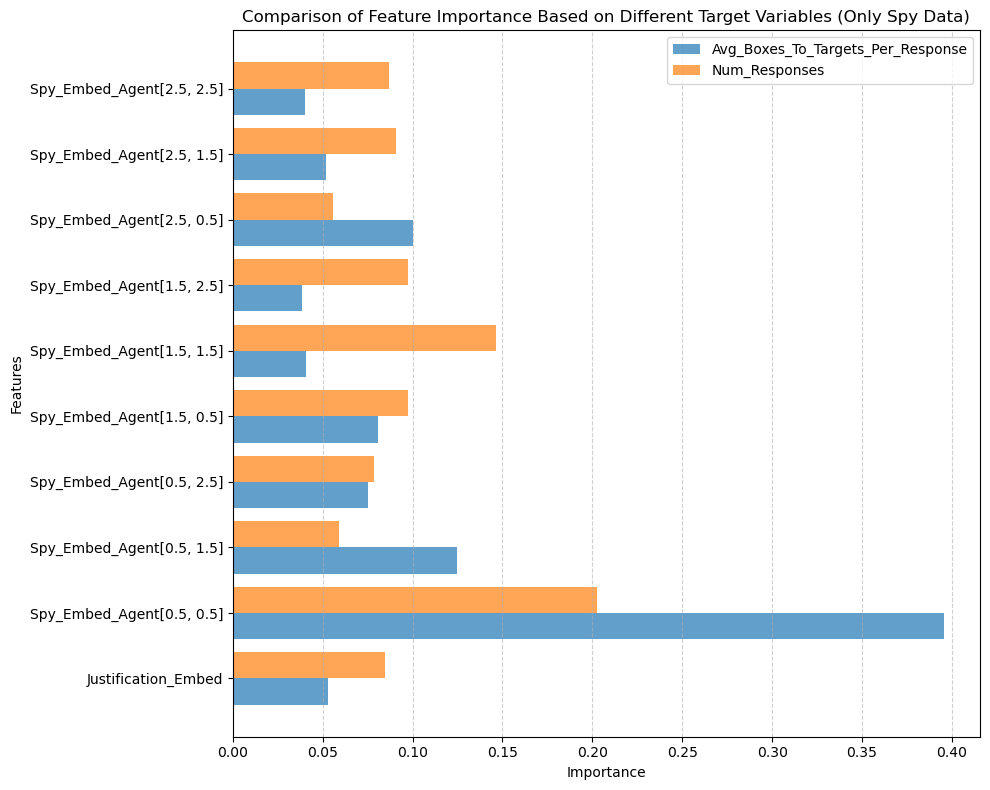

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Model 1: Train on Avg_Boxes_To_Targets_Per_Response
X1 = rplh_df_all_spy.drop(columns=["Avg_Boxes_To_Targets_Per_Response", "Num_Responses", "Num_Boxes"])
y1 = rplh_df_all_spy["Avg_Boxes_To_Targets_Per_Response"]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
model1 = RandomForestRegressor(random_state=42)
model1.fit(X_train1, y_train1)

# Model 2: Train on Num_Responses
X2 = rplh_df_all_spy.drop(columns=["Avg_Boxes_To_Targets_Per_Response", "Num_Responses", "Num_Boxes"])
y2 = rplh_df_all_spy["Num_Responses"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
model2 = RandomForestRegressor(random_state=42)
model2.fit(X_train2, y_train2)

importances1 = pd.Series(model1.feature_importances_, index=X1.columns)
importances2 = pd.Series(model2.feature_importances_, index=X2.columns)

plt.figure(figsize=(10, 8))
y = range(len(importances1))

plt.barh(y, importances1.sort_index(), height=0.4, label="Avg_Boxes_To_Targets_Per_Response", alpha=0.7)
plt.barh([i + 0.4 for i in y], importances2.sort_index(), height=0.4, label="Num_Responses", alpha=0.7)
plt.yticks([i + 0.2 for i in y], importances1.sort_index().index)
plt.title("Comparison of Feature Importance Based on Different Target Variables (Only Spy Data)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

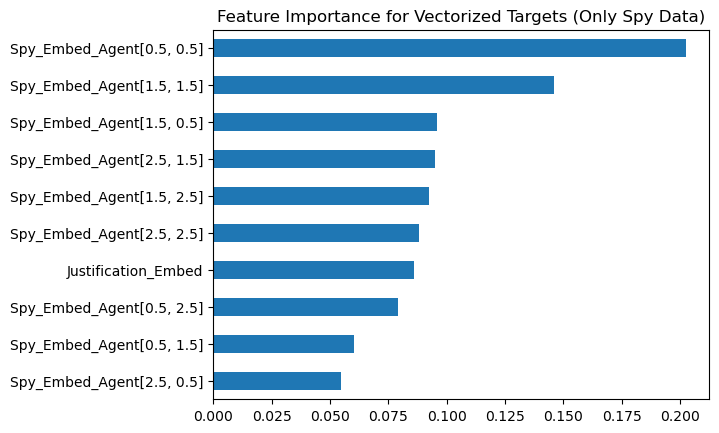

In [68]:
X = rplh_df_all_spy.drop(columns=["Avg_Boxes_To_Targets_Per_Response", "Num_Responses", "Num_Boxes"])
y = rplh_df_all_spy[["Num_Responses", "Avg_Boxes_To_Targets_Per_Response"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", title="Feature Importance for Vectorized Targets (Only Spy Data)")
plt.show()

***
# Bootstrap More Data
***

In [69]:
rplh_df.columns

Index(['Num_Boxes', 'Avg_Boxes_To_Targets_Per_Response', 'Num_Responses',
       'Spy_Embed_Agent[2.5, 0.5]', 'Spy_Embed_Agent[0.5, 2.5]',
       'Spy_Embed_Agent[0.5, 0.5]', 'Spy_Embed_Agent[0.5, 1.5]',
       'Spy_Embed_Agent[1.5, 1.5]', 'Spy_Embed_Agent[1.5, 0.5]',
       'Spy_Embed_Agent[2.5, 1.5]', 'Spy_Embed_Agent[2.5, 2.5]',
       'Spy_Embed_Agent[1.5, 2.5]', 'Justification_Embed', 'Have_spy'],
      dtype='object')

In [70]:
num_synthetic_rows = 1000
# Generate synthetic data within the min-max range of each numerical column
synthetic_data = {
    column: np.random.uniform(rplh_df[column].min(), rplh_df[column].max(), num_synthetic_rows)
    for column in rplh_df.select_dtypes(include=np.number).columns
}

# For categorical columns like 'Have_spy', sample existing values
synthetic_data['Have_spy'] = np.random.choice(rplh_df['Have_spy'], size=num_synthetic_rows)

# Convert synthetic data into a DataFrame
df_synthetic = pd.DataFrame(synthetic_data)

# Combine the original and synthetic data
df_expanded = pd.concat([rplh_df, df_synthetic], ignore_index=True)
print(f"Expanded DataFrame shape: {df_expanded.shape}")

Expanded DataFrame shape: (1060, 14)


After bootsrtap, the columns tends to be normally distributed, emphasize on the mean.

In [71]:
df_expanded

,Num_Boxes,Avg_Boxes_To_Targets_Per_Response,Num_Responses,"Spy_Embed_Agent[2.5, 0.5]","Spy_Embed_Agent[0.5, 2.5]","Spy_Embed_Agent[0.5, 0.5]","Spy_Embed_Agent[0.5, 1.5]","Spy_Embed_Agent[1.5, 1.5]","Spy_Embed_Agent[1.5, 0.5]","Spy_Embed_Agent[2.5, 1.5]","Spy_Embed_Agent[2.5, 2.5]","Spy_Embed_Agent[1.5, 2.5]",Justification_Embed,Have_spy
0,8.000000,0.571429,14.000000,0.556201,0.353954,0.675143,0.583687,0.594204,0.647790,0.615318,0.353954,0.558678,0.617001,1
1,11.000000,0.440000,25.000000,0.735305,0.689888,0.647305,0.663263,0.640134,0.726578,0.654975,0.734128,0.727824,0.500486,1
2,11.000000,0.407407,27.000000,0.601292,0.795070,0.618273,0.723797,0.684246,0.601316,0.731000,0.621723,0.655668,0.650587,1
3,10.000000,0.384615,26.000000,0.694355,0.718790,0.657759,0.518235,0.753357,0.774580,0.728039,0.733541,0.651190,0.651606,1
4,12.000000,0.307692,39.000000,0.668090,0.700136,0.528011,0.651323,0.604009,0.565760,0.655013,0.536061,0.661763,0.602094,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,7.034774,0.463869,27.000813,0.437314,0.535659,0.369990,0.445265,0.336422,0.700177,0.243869,0.575787,0.530086,0.378534,1
1056,10.109130,0.110759,38.036607,0.372859,0.207458,0.132598,0.589610,0.553088,0.496735,0.731812,0.715462,0.662362,0.096828,1
1057,13.024791,1.219767,31.196372,0.369329,0.258196,0.694178,0.084792,0.317993,0.103006,0.702560,0.667295,0.677858,0.378234,1
1058,11.010584,0.471080,42.370902,0.714300,0.562990,0.578083,0.097838,0.243794,0.134931,0.350341,0.435308,0.511709,0.040430,1


***
# Hypothesis Testing
***

Observed difference in means: -1.550
Bootstrap p-value: 0.601
Fail to reject the null hypothesis: No evidence that having a spy affects convergence.


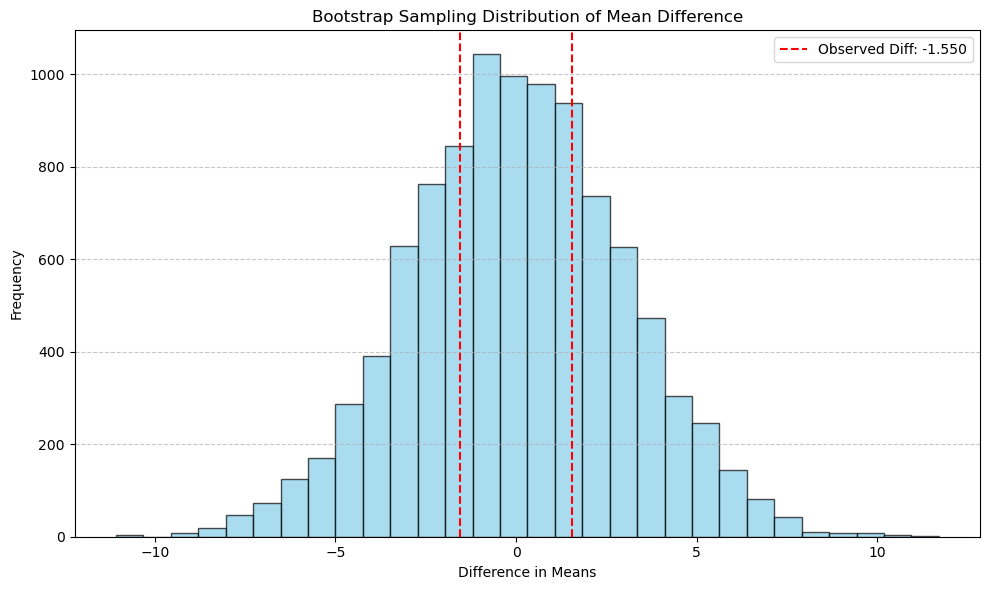

In [72]:
n_bootstrap = 10000

group_with_spy = rplh_df[rplh_df["Have_spy"] == 1]["Num_Responses"]
group_without_spy = rplh_df[rplh_df["Have_spy"] == 0]["Num_Responses"]
observed_diff = group_with_spy.mean() - group_without_spy.mean()
combined_data = np.concatenate([group_with_spy, group_without_spy])

bootstrap_diffs = []
for _ in range(n_bootstrap):
    resampled_group_with_spy = np.random.choice(combined_data, size=len(group_with_spy), replace=True)
    resampled_group_without_spy = np.random.choice(combined_data, size=len(group_without_spy), replace=True)
    bootstrap_diffs.append(resampled_group_with_spy.mean() - resampled_group_without_spy.mean())

bootstrap_diffs = np.array(bootstrap_diffs)
p_bootstrap = np.mean(np.abs(bootstrap_diffs) >= np.abs(observed_diff))
print(f"Observed difference in means: {observed_diff:.3f}")
print(f"Bootstrap p-value: {p_bootstrap:.3f}")

alpha = 0.1
if p_bootstrap < alpha:
    print("Reject the null hypothesis: Having a spy significantly slows down convergence.")
else:
    print("Fail to reject the null hypothesis: No evidence that having a spy affects convergence.")

plt.figure(figsize=(10, 6))
plt.hist(bootstrap_diffs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='--', label=f'Observed Diff: {observed_diff:.3f}')
plt.axvline(-observed_diff, color='red', linestyle='--')
plt.title('Bootstrap Sampling Distribution of Mean Difference')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

***
# Dimensionality Reduction
***

Explained Variance Ratio: [0.81231264 0.08792212]


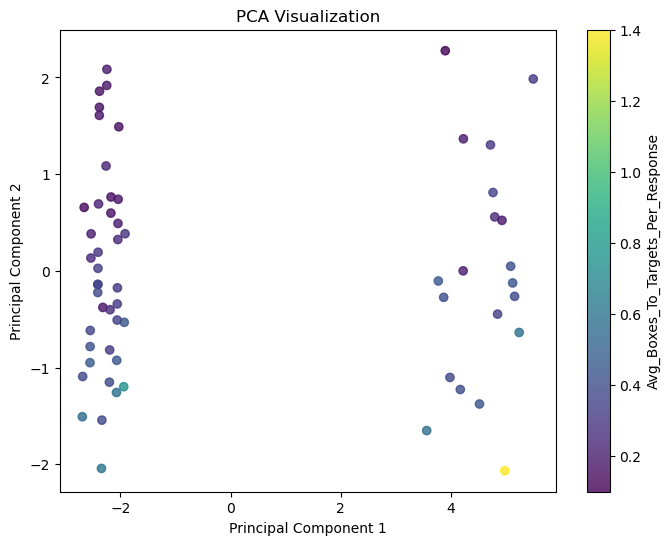

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

numeric_features = rplh_df.select_dtypes(include="number").drop(columns=["Avg_Boxes_To_Targets_Per_Response"])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_features)

pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(pca_results, columns=["PC1", "PC2"])
pca_df["Avg_Boxes_To_Targets_Per_Response"] = rplh_df["Avg_Boxes_To_Targets_Per_Response"]
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_df["PC1"], pca_df["PC2"],
    c=pca_df["Avg_Boxes_To_Targets_Per_Response"], cmap="viridis", alpha=0.8
)
plt.colorbar(scatter, label="Avg_Boxes_To_Targets_Per_Response")
plt.title("PCA Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

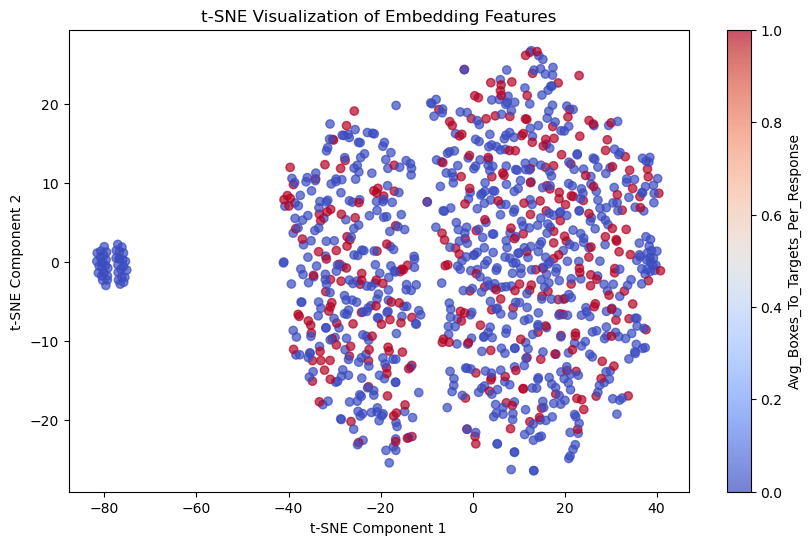

In [74]:
from sklearn.manifold import TSNE

embedding_features = df_expanded.select_dtypes(include="number").drop(columns=["Avg_Boxes_To_Targets_Per_Response"])

scaler = StandardScaler()
embedding_features_scaled = scaler.fit_transform(embedding_features)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embedding_features_scaled)
df_expanded['TSNE_1'] = tsne_results[:, 0]
df_expanded['TSNE_2'] = tsne_results[:, 1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_expanded['TSNE_1'], df_expanded['TSNE_2'], c=(df_expanded['Avg_Boxes_To_Targets_Per_Response']).astype(int), cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Avg_Boxes_To_Targets_Per_Response')
plt.title('t-SNE Visualization of Embedding Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

/Users/kevinb/miniforge3/envs/rplh/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


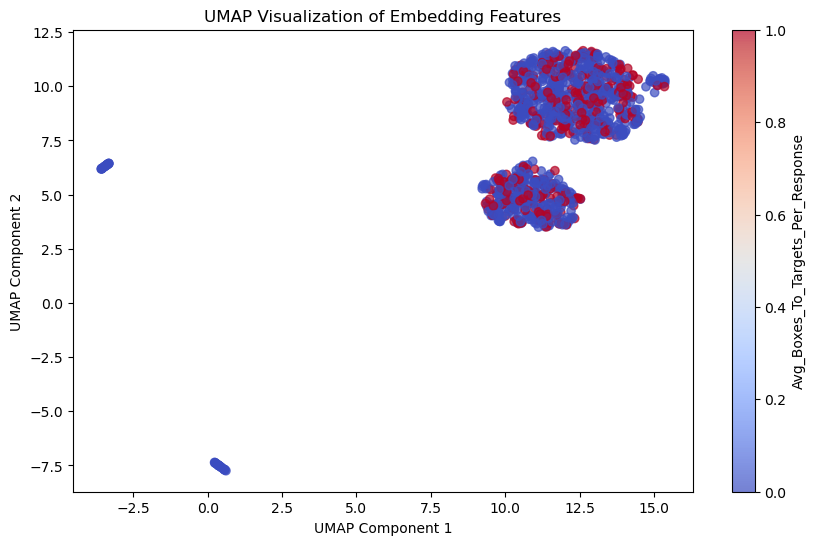

In [75]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_model.fit_transform(embedding_features_scaled)
df_expanded['UMAP_1'] = umap_results[:, 0]
df_expanded['UMAP_2'] = umap_results[:, 1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_expanded['UMAP_1'], df_expanded['UMAP_2'], c=(df_expanded['Avg_Boxes_To_Targets_Per_Response']).astype(int), cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, label='Avg_Boxes_To_Targets_Per_Response')
plt.title('UMAP Visualization of Embedding Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

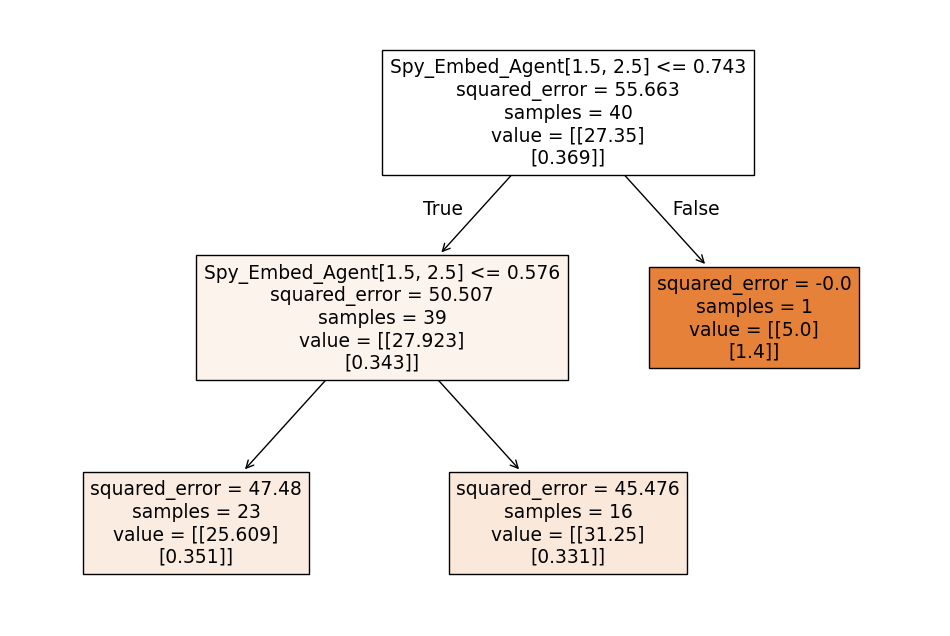

In [76]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

X = rplh_df_all_spy.drop(columns=["Avg_Boxes_To_Targets_Per_Response", "Num_Responses", "Num_Boxes"])
y = rplh_df_all_spy[["Num_Responses", "Avg_Boxes_To_Targets_Per_Response"]]
tree = DecisionTreeRegressor(max_depth=2, random_state=42)
tree.fit(X, y)

plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, filled=True)
plt.show()

***
# Comparing Performance Across Systems All Together
***

We have created functions to yield overall comparison

In [32]:
from rplh.evaluation.evals import get_all_evals

In [33]:
# dummy1 = pd.DataFrame(np.nan, index=spy_df.index, columns=spy_df.columns)
dummy2 = pd.DataFrame(np.nan, index=justification_df.index, columns=justification_df.columns)

In [45]:
eval_agent_spy = get_all_evals(df_a_spy, success_df_a_spy, spy_df, justification_df, dist_a_spy, system="rplh-agent-spy")
eval_standard_spy = get_all_evals(df_s_spy, success_df_s_spy, _, justification_df_standard, dist_s_spy, system="rplh-standard-spy")
eval_standard_nospy = get_all_evals(df_s_nospy, success_df_s_nospy, _, dummy2, dist_s_nospy, system="rplh-standard-nospy")

Overall AUC for Norm1: 187.71428571428572
Overall AUC for Norm2: 108.59262775932079
Average slope for Norm1: -0.38765125806035183
Average slope for Norm2: -0.2704926585392068
Overall AUC for Norm1: 228.8181818181818
Overall AUC for Norm2: 133.27889394692093
Average slope for Norm1: -0.3326826865160759
Average slope for Norm2: -0.23993066999109416
Overall AUC for Norm1: 160.29166666666666
Overall AUC for Norm2: 87.45310554402722
Average slope for Norm1: -0.5668572673651545
Average slope for Norm2: -0.3335389614962636
Justification df is empty, no embedding similarity calculated.


In [47]:
final = eval_agent_spy.join(eval_standard_spy).join(eval_standard_nospy)
final.round(3)

,rplh-agent-spy,rplh-standard-spy,rplh-standard-nospy
Average-AUC-Norm1,187.714,228.818,160.292
Average-AUC-Norm2,108.593,133.279,87.453
Average-Slope1,-0.388,-0.333,-0.567
Average-Slope2,-0.270,-0.240,-0.334
Average-Box-To-Targets-Per-Response,0.406,0.271,0.290
Average-Responses,28.400,35.800,28.900
Average-Convergence-Rate,0.700,0.550,0.600
"Average-Embedding-Similarity-Spy_Embed_Agent[0.5, 0.5]",0.563,NaN,NaN
"Average-Embedding-Similarity-Spy_Embed_Agent[2.5, 2.5]",0.647,NaN,NaN
"Average-Embedding-Similarity-Spy_Embed_Agent[1.5, 1.5]",0.622,NaN,NaN


In [48]:
from tabulate import tabulate
markdown_table = tabulate(final.round(3), headers='keys', tablefmt='pipe')
print(markdown_table)

|                                                        |   rplh-agent-spy |   rplh-standard-spy |   rplh-standard-nospy |
|:-------------------------------------------------------|-----------------:|--------------------:|----------------------:|
| Average-AUC-Norm1                                      |          187.714 |             228.818 |               160.292 |
| Average-AUC-Norm2                                      |          108.593 |             133.279 |                87.453 |
| Average-Slope1                                         |           -0.388 |              -0.333 |                -0.567 |
| Average-Slope2                                         |           -0.27  |              -0.24  |                -0.334 |
| Average-Box-To-Targets-Per-Response                    |            0.406 |               0.271 |                 0.29  |
| Average-Responses                                      |           28.4   |              35.8   |                28.9   |
| Averag